In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

df_y2 = pd.read_csv('../data/train_test/rf_data_Y2.csv')
df_y3 = pd.read_csv('../data/train_test/rf_data_Y3.csv')

#df_y2 = df_y2.sample(n=10000, random_state=42)
df_y2

,AgeAtFirstClaim,ClaimsCount,Unique_ProviderID,Unique_Vendor,PayDelay,Diagnostic Imaging,Emergency,General Practice,Internal,Surgery,...,1-2,EM,MED,PL,RAD,SDS,0- 1 month,DrugCount,LabCount,DaysInHospital
0,35.0,6.0,3.0,3.0,308.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,4.0,1.0,0.0,0.0,2.0,0.0,1.0,0
1,5.0,5.0,4.0,3.0,148.0,1.0,0.0,0.0,1.0,0.0,...,0.0,2.0,0.0,1.0,1.0,0.0,1.0,3.0,2.0,0
2,15.0,11.0,8.0,8.0,608.0,3.0,3.0,0.0,1.0,1.0,...,0.0,3.0,0.0,1.0,4.0,1.0,7.0,0.0,3.0,1
3,5.0,12.0,4.0,4.0,637.0,1.0,0.0,4.0,0.0,0.0,...,0.0,3.0,3.0,3.0,1.0,0.0,3.0,0.0,5.0,0
4,35.0,8.0,6.0,5.0,320.0,1.0,1.0,3.0,2.0,0.0,...,0.0,6.0,0.0,1.0,1.0,0.0,1.0,13.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51961,65.0,16.0,5.0,4.0,553.0,0.0,0.0,8.0,1.0,0.0,...,0.0,7.0,3.0,5.0,0.0,0.0,8.0,10.0,13.0,0
51962,80.0,14.0,6.0,4.0,1081.0,1.0,0.0,8.0,3.0,0.0,...,10.0,5.0,2.0,3.0,1.0,0.0,3.0,22.0,5.0,0
51963,15.0,4.0,3.0,3.0,115.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,3.0,0
51964,65.0,6.0,2.0,2.0,235.0,0.0,0.0,0.0,6.0,0.0,...,3.0,4.0,0.0,0.0,0.0,0.0,5.0,27.0,0.0,0


In [2]:
# get features and label from the the data
X_y2 = df_y2.drop(['DaysInHospital'], axis=1)
y_y2 = df_y2['DaysInHospital']

X_y3 = df_y3.drop(['DaysInHospital'], axis=1)
y_y3 = df_y3['DaysInHospital'] 

In [3]:
# Use the optimal hyperparameters to train the final model and make predictions
final_model = RandomForestRegressor(n_estimators=180, max_depth= 9, random_state=42, n_jobs=-1)
final_model.fit(X_y2, y_y2)
y_pred_y3 = final_model.predict(X_y3)

# Evaluate the model's performance on the third year's data
mse_y3 = mean_squared_error(y_y3, y_pred_y3)
print(f"Mean Squared Error on Year 3 data(hyperparameter changed model): {mse_y3}")

Mean Squared Error on Year 3 data(hyperparameter changed model): 0.6451144060082578


In [4]:
def k_fold_cross_validation(X, y, k, model):
    """
    Implement k-fold cross validation.

    Parameters:
    X: feature dataset.
    y: label dataset.
    k: number of folds (k in k-fold).
    model: model to be trained (model trained on each fold).

    Return value:
    Returns the mean and standard deviation of the mean squared error (MSE).
    """
    np.random.seed(42)
    fold_size = len(X) // k  # Size of each fold
    indices = np.random.permutation(len(X))  # Randomly shuffle the dataset
    mse_scores = []  # Store the MSE of each fold

    # Perform k-fold cross validation
    for i in range(k):
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]

        # Train the model and make predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    # Return the mean and standard deviation of the mean square error
    return np.mean(mse_scores), np.std(mse_scores)


In [5]:
# Function to generate learning curves and plot error bars
def plot_learning_curve_with_error_bars(X, y, model, train_sizes=np.linspace(0.1, 1.0, 10), repetitions=20, k=5):
    """
    Plot learning curve with error bars for a given model across repetitions.
    
    Parameters:
    X, y : Dataset (features and labels)
    model : Model to be trained
    train_sizes : Array of training sizes (e.g., [0.1, 0.2, ..., 1.0])
    repetitions : Number of independent repetitions for error bar computation
    k : Number of folds for cross-validation
    
    Returns:
    Learning curves with error bars
    """
    train_errors = []
    validation_errors = []
    
    for train_size in train_sizes:
        train_mse_reps = []
        val_mse_reps = []
        
        for _ in range(repetitions):
            # Split data into training and validation sets
            X_train, y_train = X.sample(frac=train_size), y.sample(frac=train_size)
            X_val, y_val = X.drop(X_train.index), y.drop(y_train.index)

            # K-fold cross-validation
            train_mse, val_mse = k_fold_cross_validation(X_train, y_train, k, model)
            train_mse_reps.append(train_mse)
            val_mse_reps.append(val_mse)
        
        # Compute mean and std across repetitions for error bars
        train_errors.append((np.mean(train_mse_reps), np.std(train_mse_reps)))
        validation_errors.append((np.mean(val_mse_reps), np.std(val_mse_reps)))

    # Plotting the learning curve
    train_means, train_stds = zip(*train_errors)
    val_means, val_stds = zip(*validation_errors)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_means, 'o-', label='Training Error', color='blue')
    plt.plot(train_sizes, val_means, 'o-', label='Validation Error', color='green')

    # Add error bars
    plt.fill_between(train_sizes, np.array(train_means) - np.array(train_stds), 
                     np.array(train_means) + np.array(train_stds), alpha=0.2, color='blue')
    plt.fill_between(train_sizes, np.array(val_means) - np.array(val_stds), 
                     np.array(val_means) + np.array(val_stds), alpha=0.2, color='green')

    plt.title('Learning Curve with Error Bars (MSE)')
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()



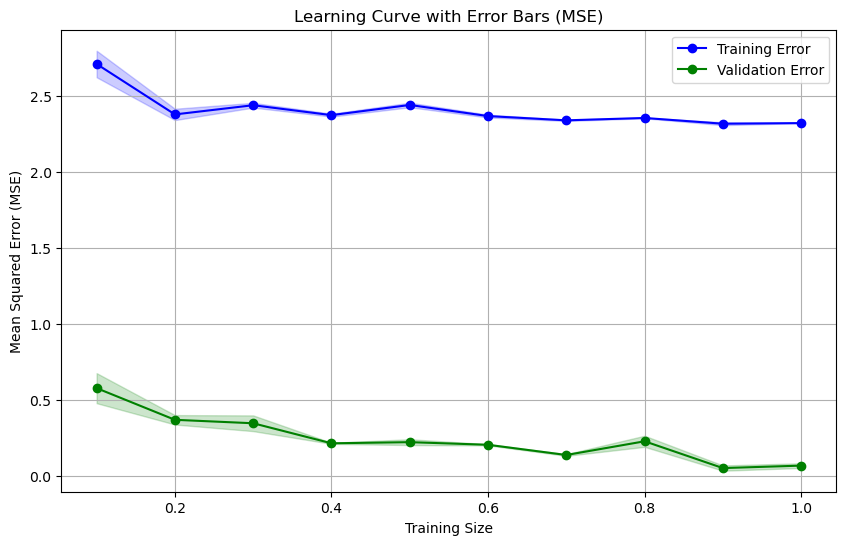

In [6]:
# Assuming X and y are your dataset and labels
final_model = RandomForestRegressor(n_estimators=180, max_depth=9, random_state=42, n_jobs=-1)
plot_learning_curve_with_error_bars(X_y2, y_y2, final_model)

In [7]:
# Use the optimal hyperparameters to train the final model and make predictions
final_model = RandomForestRegressor(max_depth= 9, random_state=42, n_jobs=-1)
final_model.fit(X_y2, y_y2)
y_pred_y3 = final_model.predict(X_y3)

# Evaluate the model's performance on the third year's data
mse_y3 = mean_squared_error(y_y3, y_pred_y3)
print(f"Mean Squared Error on Year 3 data(hyperparameter changed model): {mse_y3}")

Mean Squared Error on Year 3 data(hyperparameter changed model): 0.6473559787410311
